<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250716/k%E3%82%BB%E3%83%B3%E3%82%BF%E3%83%BC%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###準備
20250716


In [ ]:
%%capture
# python-mip ライブラリをインストールする
!pip install mip

# Matplotlibで日本語を表示するためのライブラリをインストール
!pip install japanize-matplotlib

# 必要なライブラリをインポートする
import mip
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # ← 日本語表示のためにインポート
import random
from math import sqrt
from itertools import product
from scipy.spatial.distance import cdist # 距離行列計算用

#k-センター問題

本講義では、「k-センター問題 (k-Center Problem)」を取り上げます。k-センター問題は、限られた数の施設を配置する際に、全ての需要地点（顧客）がサービスを受けるにあたって、**最も不利な状況にある需要地点の状況をできる限り良くする**、つまり「最大」のサービス距離（またはコスト）を「最小化」することを目的とします。これは公平性や均一なサービス提供が重視される場面で特に重要な問題です。

例えば、緊急施設（消防署や救急病院）を配置する場合、全ての住民が一定時間内にサービスを受けられるように、最も遠い住民への到達時間を短縮することが求められます。k-センター問題は、このような「最悪ケースの最小化（ミニマックス最適化）」という考え方に基づいています。

本講義の目標は以下の通りです。

1.  k-センター問題の基本的な概念、k-メディアン問題との目的の違い、および実社会での応用を理解する。
2.  k-センター問題を数理モデル（整数計画問題）として定式化する手法を習得する。
3.  Pythonの最適化ライブラリ `python-mip` を用いてk-センター問題を実際に解く
プログラミングスキルを身につける。


## 問題の定義

k-センター問題は、与えられた複数の需要地点と、複数の潜在的な施設建設候補地の中から、**$k$ 個の施設を建設し**、各需要地点をいずれか一つの開設された施設に割り当てたとき、**全ての需要地点とその割り当てられた施設との間の距離のうち、その最大値が最小となるように**施設を配置し、割り当てを行う問題である。

言い換えると、どの需要地点も、最も近い施設からあまり遠くないように、つまり最もサービスが行き届きにくい需要地点へのアクセスを可能な限り良くすることを目指す。

  * **入力**:
      * 需要地点の集合
   $I = \{0, 1, \dots, n-1\}$。
      * 施設建設候補地の集合
   $J = \{0, 1, \dots, m-1\}$。（本講義では $I=J$ とし、$n=m$ とする。）
      * 各需要地点 $i \\in I$ から各施設建設候補地 $j \\in J$ への距離またはコスト $d\_{ij}$。
      * 開設する施設の数 $k$。
  * **出力**:
      * 開設する $k$ 個の施設の位置の決定。
      * 各需要地点を、開設された $k$ 個の施設のうちのいずれか一つに割り当てる方法。
      * 最小化された「最大割り当て距離」（カバレッジ半径とも呼ばれる）。
  * **目的**:
      * 各需要地点から割り当てられた施設への距離の**最大値**を最小化する。

### k-メディアン問題との違い

k-メディアン問題とk-センター問題は、どちらも $k$ 個の施設を配置する問題ですが、目的関数が異なります。

  * **k-メディアン問題**: 全ての需要地点から割り当て施設への**総距離**（または平均距離）を最小化する。全体の効率性を重視する。
  * **k-センター問題**: 全ての需要地点から割り当て施設への距離の**最大値**（最悪ケース）を最小化する。公平性や均等なサービスレベルを重視する。

この目的の違いにより、同じ地点配置でも最適な施設の場所が異なることがあります。


### 簡単な例題と図解

k-メディアン問題で使用した6つの需要地点 (0から9) の例で、$k=2$ 個の施設（センター）を選ぶ場合を考える。

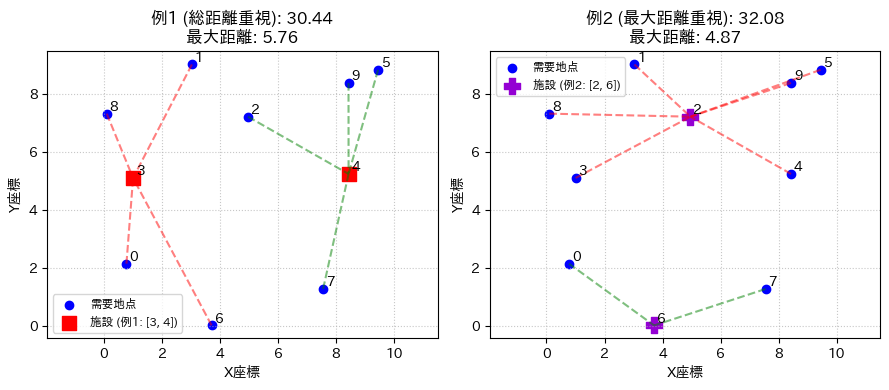

例1 (施設:[3, 4]): 総距離=30.44, 最大距離=5.76
例2 (施設:[2, 6]): 総距離=32.08, 最大距離=4.87

k-センター問題の目的は、例2のような配置で「最大距離」をできるだけ小さくすることです。
このとき、総距離は必ずしも最小になるとは限りません。


In [ ]:
#@title 図解
# k-メディアン問題の例題データを再利用
num_demand_points_ex_kc = 10

random.seed(32) # 再現性のため
demand_coords_ex_kc = np.array([(random.uniform(0,10), random.uniform(0,10)) for _ in range(num_demand_points_ex_kc)])
dist_matrix_ex_kc = cdist(demand_coords_ex_kc, demand_coords_ex_kc, 'euclidean')

# 図示のための準備
plt.figure(figsize=(9,4))

# k-メディアン的な解の例 (地点0と3に施設)
plt.subplot(1, 2, 1)
plt.scatter(demand_coords_ex_kc[:,0], demand_coords_ex_kc[:,1], c='blue', label='需要地点')
for i in range(num_demand_points_ex_kc):
    plt.text(demand_coords_ex_kc[i,0]+0.1, demand_coords_ex_kc[i,1]+0.1, str(i))

facility_locations_median_like = [3, 4]
max_dist_median_like = 0
total_dist_median_like = 0
for i in range(num_demand_points_ex_kc):
    dist_to_fac0 = dist_matrix_ex_kc[i, facility_locations_median_like[0]]
    dist_to_fac3 = dist_matrix_ex_kc[i, facility_locations_median_like[1]]
    assigned_dist = min(dist_to_fac0, dist_to_fac3)
    total_dist_median_like += assigned_dist
    if assigned_dist > max_dist_median_like:
        max_dist_median_like = assigned_dist

    if dist_to_fac0 <= dist_to_fac3:
        plt.plot([demand_coords_ex_kc[i,0], demand_coords_ex_kc[facility_locations_median_like[0],0]],
                 [demand_coords_ex_kc[i,1], demand_coords_ex_kc[facility_locations_median_like[0],1]], 'r--', alpha=0.5)
    else:
        plt.plot([demand_coords_ex_kc[i,0], demand_coords_ex_kc[facility_locations_median_like[1],0]],
                 [demand_coords_ex_kc[i,1], demand_coords_ex_kc[facility_locations_median_like[1],1]], 'g--', alpha=0.5)

plt.scatter(demand_coords_ex_kc[facility_locations_median_like,0], demand_coords_ex_kc[facility_locations_median_like,1],
            c='red', marker='s', s=100, label=f'施設 (例1: {facility_locations_median_like})')
plt.title(f"例1 (総距離重視): {total_dist_median_like:.2f}\n最大距離: {max_dist_median_like:.2f}")
plt.xlabel("X座標"); plt.ylabel("Y座標"); plt.grid(True, linestyle=':', alpha=0.7); plt.axis('equal'); plt.legend(fontsize='small')


# k-センター的な解の例 (異なる施設配置で最大距離を小さくする試み)
# 例えば施設を地点1と4に建設 (これは手動で調整した例)
plt.subplot(1, 2, 2)
plt.scatter(demand_coords_ex_kc[:,0], demand_coords_ex_kc[:,1], c='blue', label='需要地点')
for i in range(num_demand_points_ex_kc):
    plt.text(demand_coords_ex_kc[i,0]+0.1, demand_coords_ex_kc[i,1]+0.1, str(i))

facility_locations_center_like = [2, 6] # 例として変更
max_dist_center_like = 0
total_dist_center_like = 0
for i in range(num_demand_points_ex_kc):
    dist_to_fac1 = dist_matrix_ex_kc[i, facility_locations_center_like[0]]
    dist_to_fac4 = dist_matrix_ex_kc[i, facility_locations_center_like[1]]
    assigned_dist = min(dist_to_fac1, dist_to_fac4)
    total_dist_center_like += assigned_dist
    if assigned_dist > max_dist_center_like:
        max_dist_center_like = assigned_dist

    if dist_to_fac1 <= dist_to_fac4:
        plt.plot([demand_coords_ex_kc[i,0], demand_coords_ex_kc[facility_locations_center_like[0],0]],
                 [demand_coords_ex_kc[i,1], demand_coords_ex_kc[facility_locations_center_like[0],1]], 'r--', alpha=0.5)
    else:
        plt.plot([demand_coords_ex_kc[i,0], demand_coords_ex_kc[facility_locations_center_like[1],0]],
                 [demand_coords_ex_kc[i,1], demand_coords_ex_kc[facility_locations_center_like[1],1]], 'g--', alpha=0.5)

plt.scatter(demand_coords_ex_kc[facility_locations_center_like,0], demand_coords_ex_kc[facility_locations_center_like,1],
            c='darkviolet', marker='P', s=120, label=f'施設 (例2: {facility_locations_center_like})')
plt.title(f"例2 (最大距離重視): {total_dist_center_like:.2f}\n最大距離: {max_dist_center_like:.2f}")
plt.xlabel("X座標"); plt.ylabel("Y座標"); plt.grid(True, linestyle=':', alpha=0.7); plt.axis('equal'); plt.legend(fontsize='small')

plt.tight_layout()
plt.show()

print(f"例1 (施設:{facility_locations_median_like}): 総距離={total_dist_median_like:.2f}, 最大距離={max_dist_median_like:.2f}")
print(f"例2 (施設:{facility_locations_center_like}): 総距離={total_dist_center_like:.2f}, 最大距離={max_dist_center_like:.2f}")
print("\nk-センター問題の目的は、例2のような配置で「最大距離」をできるだけ小さくすることです。")
print("このとき、総距離は必ずしも最小になるとは限りません。")

**図の説明**:
左の図(例1)は、総距離を重視するk-メディアン的な考え方で施設を3と4に置いた場合の例で、総距離は比較的小さいですが、一部の地点（例：地点6から施設3）は遠く、
最大距離が大きくなります。
右の図(例2)は、最大距離を小さくすることを意識して施設を2と6に置いた場合の例です。この配置では、最も遠い需要地点への距離が例1よりも小さくなる可能性がありますが、全体の総距離は例1より大きくなります。
k-センター問題は、この右図のような「最大距離」を最小にする施設の配置を探します。

### 実社会での応用例

k-センター問題は、特に公平性やカバレッジの均一性が求められる場面で有効である。

  * **緊急施設の配置**:
      * 消防署、救急病院、警察署、避難所など。どの市民もできるだけ早くサービスを受けられるように、最も遠い市民への到達時間（距離）を最小化する。
  * **公共サービス施設の配置**:
      * 郵便ポスト、投票所、図書館の分館など。住民がどの施設にもアクセスしにくいという状況を避けるため、最大アクセス距離を抑える。
  * **商業インフラの配置**:
      * ATM、公衆電話（古い例だが）、電気自動車の充電ステーションなど。利用者が最寄りの施設を見つけやすいように、サービス提供範囲の「穴」をなくす。
  * **通信・センサーネットワーク**:
      * 無線LANアクセスポイント、携帯電話基地局、環境監視センサーなどを配置し、全てのターゲットエリアがいずれかの局やセンサーの有効範囲内（一定距離内）に収まるようにする。その際の最大距離（または必要な最小半径）を最小化する。
  * **危険物処理施設・廃棄物処理施設の配置**:
    居住地域からの最大距離を確保しつつ（これは逆の考え方だが、中心の概念は同じ）、または複数の処理施設を配置して各地域からの輸送距離の最大値を抑える。

これらの応用では、一部の利用者が極端に不便を被ることを避けるという、公平性の観点からの最適化が図られる。

## 数理モデルによる定式化

k-センター問題を整数計画問題として定式化する。

### 決定変数

  * $y_j$: 施設建設候補地 $j \in J$ に施設（センター）を開設するならば $1$、
  そうでないならば $0$ をとるバイナリ変数。
  * $x_{ij}$: 需要地点 $i \in I$ を、施設建設候補地 $j \in J$ に開設された施設に割り当てるならば $1$、そうでないならば $0$ をとるバイナリ変数。
  * $Z$: 全ての需要地点から、それぞれ割り当てられた施設への距離の**最大値**を示す連続変数。この $Z$ を最小化することが目的となる。

### パラメータ

  * $I = \{0, 1, \dots, n-1\}$: 需要地点の集合。
  * $J = \{0, 1, \dots, m-1\}$: 施設建設候補地の集合 ($I=J$ と仮定)。
  * $d_{ij}$: 需要地点 $i$ から施設候補地 $j$ への距離またはコスト。
  * $k$: 開設する施設の数。

### 目的関数

全ての需要地点から割り当てられた施設への距離の最大値 $Z$ を最小化する。

$$\min Z$$

### 制約条件

1.  **割り当て制約**:
    各需要地点 $i$ は、いずれか一つの施設 $j$ に割り当てられなければならない。
    $$\sum_{j \in J} x_{ij} = 1 \quad \forall i \in I$$

2.  **施設開設連動制約**:
    需要地点 $i$ を施設候補地 $j$ に割り当てる ($x\_{ij}=1$) ことができるのは、その候補地 $j$ に実際に施設が開設されている ($y\_j=1$) 場合のみである。
    $$x_{ij} \le y_j \quad \forall i \in I, \forall j \in J$$

3.  **施設数制約**:
    開設される施設の総数は、指定された数 $k$ に等しくなければならない。
    $$\sum_{j \in J} y_j = k$$

4.  **最大距離定義制約 (カバレッジ制約)**:
    各需要地点 $i$ について、それが割り当てられた施設への実際の距離は、$Z$ 以下でなければならない。
    需要地点 $i$ が施設 $j$ に割り当てられる($x\_{ij}=1$)とき、その距離は $d\_{ij}$ である。この距離が $Z$ を超えてはならない。
    これは、各需要地点 $i$ について、$\\sum\_{j \\in J} d\_{ij} x\_{ij}$ がその地点 $i$ から割り当て先施設への距離となることを利用し、以下のように表現できる。
    $$\sum_{j \in J} d_{ij} x_{ij} \le Z \quad \forall i \in I$$
    この制約により、$Z$ は全ての割り当て距離以上の値を取ることになり、目的関数 $\\min Z$ によって、可能な限り小さい「最大の割り当て距離」が達成される。

5.  **変数型制約**:
    $$x_{ij} \in \{0, 1\} \quad \forall i \in I, \forall j \in J$$$$y_j \in \{0, 1\} \quad \forall j \in J$$$$Z \ge 0 \quad \text{(連続変数)}$$



### 数理モデルのまとめ

**目的関数**:
$$\min Z$$

**制約条件**:

1.  $\sum\_{j \in J} x_{ij} = 1 \quad \forall i \in I$
2.  $x_{ij} \le y_j \quad \forall i \in I, \forall j \in J$
3.  $\sum_{j \in J} y_j = k$
4.  $\sum_{j \in J} d_{ij} x_{ij} \le Z \quad \forall i \in I$
5.  $x_{ij} \in {0, 1} \quad \forall i \in I, \forall j \in J$
6.  $y_j \in {0, 1} \quad \forall j \in J$
7.  $Z \ge 0$

この定式化は、k-センター問題の標準的なものの一つである。

## Python MIP を用いた実装

`python-mip` を用いて、上記のk-センター問題を解く。
k-メディアン問題と同様に、地点の座標をランダムに生成し、距離はユークリッド距離を用いる。

### 問題データの設定

総地点数 (需要地点/施設候補地): 15
開設する施設数 (k): 3


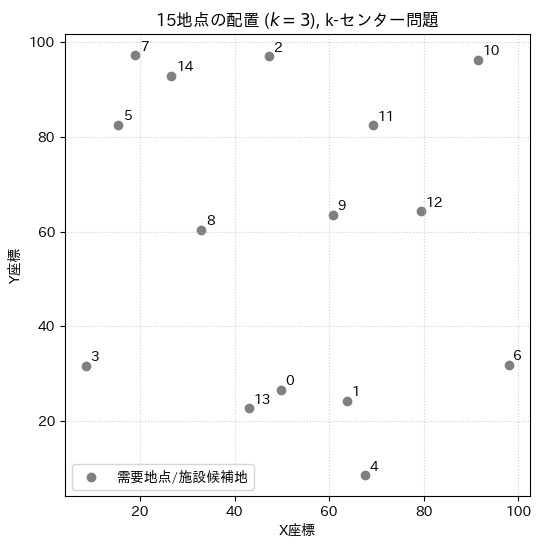

In [ ]:
# 地点数 (需要地点数 = 施設候補地数)
num_locations_kc = 15 # 例として15地点
k_centers_to_locate = 3    # 開設する施設数 (センター数)

# 地点の座標をランダムに生成 (k-メディアン問題の時と同じものを使うため、シードを合わせる)
random.seed(50)
locations_coords_kc = np.array([(random.uniform(0,100), random.uniform(0,100)) for _ in range(num_locations_kc)])

# 距離行列の計算 (ユークリッド距離)
dist_matrix_kc = cdist(locations_coords_kc, locations_coords_kc, 'euclidean')

print(f"総地点数 (需要地点/施設候補地): {num_locations_kc}")
print(f"開設する施設数 (k): {k_centers_to_locate}")

# 地点のプロット (初期状態)
plt.figure(figsize=(6,6))
plt.scatter(locations_coords_kc[:,0], locations_coords_kc[:,1], c='gray', marker='o', label='需要地点/施設候補地')
for i in range(num_locations_kc):
    plt.text(locations_coords_kc[i,0]+1, locations_coords_kc[i,1]+1, str(i))
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title(f"{num_locations_kc}地点の配置 ($k={k_centers_to_locate}$), k-センター問題")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal')
plt.show()

### モデルの作成と変数の定義

  * $y_j$: 施設建設候補地 $j \in J$ に施設（センター）を開設するならば $1$、
  そうでないならば $0$ をとるバイナリ変数。
  * $x_{ij}$: 需要地点 $i \in I$ を、施設建設候補地 $j \in J$ に開設された施設に割り当てるならば $1$、そうでないならば $0$ をとるバイナリ変数。
  * $Z$: 全ての需要地点から、それぞれ割り当てられた施設への距離の**最大値**を示す連続変数。


In [ ]:
# モデルの作成
model_kcenter = mip.Model(name="k_center", sense=mip.MINIMIZE, solver_name=mip.CBC)

# インデックスの集合
I_nodes_kc = range(num_locations_kc)
J_nodes_kc = range(num_locations_kc)

# 変数の定義
# y_j: 施設候補地 j に施設を開設するなら1
y_kc = [model_kcenter.add_var(var_type=mip.BINARY, name=f"y_{j}") for j in J_nodes_kc]

# x_ij: 需要地点 i を施設 j に割り当てるなら1
x_kc = {(i,j): model_kcenter.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}")
        for i in I_nodes_kc for j in J_nodes_kc}

# Z: 最大割り当て距離 (連続変数)
Z_kc = model_kcenter.add_var(name="Z_max_distance", lb=0.0) # 下限は0

### 目的関数の設定

全ての需要地点から割り当てられた施設への距離の最大値 $Z$ を最小化する。

$$\min Z$$

In [ ]:
# 目的関数の設定
model_kcenter.objective = Z_kc

### 制約条件の追加

1.  $\sum_{j \in J} x_{ij} = 1, \quad \forall i \in I$
2.  $x_{ij} \le y_j, \quad \forall i \in I, \forall j \in J$
3.  $\sum_{j \in J} y_j = k,$
4.  $\sum_{j \in J} d_{ij} x_{ij} \le Z, \quad \forall i \in I$

In [ ]:
# 制約条件の追加

# 制約1: 各需要地点iは、いずれか一つの施設jに割り当てられる
for i in I_nodes_kc:
    model_kcenter += mip.xsum(x_kc[(i,j)] for j in J_nodes_kc) == 1, f"assign_cust_{i}"

# 制約2: 需要地点iは、施設jが開設されている場合にのみ割り当て可能
for i in I_nodes_kc:
    for j in J_nodes_kc:
        model_kcenter += x_kc[(i,j)] <= y_kc[j], f"link_assign_open_{i}_{j}"

# 制約3: 開設する施設の総数は k 個
model_kcenter += mip.xsum(y_kc[j] for j in J_nodes_kc) == k_centers_to_locate, f"num_facilities_is_k"

# 制約4: 最大距離の定義
# 各需要地点iについて、割り当てられた施設への距離がZ以下である
for i in I_nodes_kc:
    model_kcenter += mip.xsum(dist_matrix_kc[i,j] * x_kc[(i,j)] for j in J_nodes_kc) <= Z_kc, f"max_dist_constr_{i}"

### 問題の求解と結果の表示・可視化

In [ ]:
# 問題の求解
print(f"k-センター問題の最適化を開始します (k={k_centers_to_locate})...")
time_limit_kcenter_sec = 120
status_kcenter = model_kcenter.optimize(max_seconds=time_limit_kcenter_sec)

# 結果の表示
if status_kcenter == mip.OptimizationStatus.OPTIMAL or status_kcenter == mip.OptimizationStatus.FEASIBLE:
    if status_kcenter == mip.OptimizationStatus.OPTIMAL:
        print(f"最適解が見つかりました！")
    else:
        print(f"実行可能解が見つかりました（最適ではない可能性あり）。")

    minimized_max_dist = Z_kc.x # model_kcenter.objective_value と同じはず
    print(f"最小化された最大割り当て距離 (Z): {minimized_max_dist:.2f}")

    opened_centers = [j for j in J_nodes_kc if y_kc[j].x >= 0.99]
    print(f"\n開設されたセンターの位置 (インデックス): {opened_centers}")

    assignments_kc = {}
    actual_distances = []
    for i in I_nodes_kc:
        for j in J_nodes_kc:
            if x_kc[(i,j)].x >= 0.99:
                assignments_kc[i] = j
                actual_distances.append(dist_matrix_kc[i,j])
                break

    if actual_distances:
         print(f"  実際の最大割り当て距離(確認用): {max(actual_distances):.2f}")
    # print(f"各需要地点の割り当て先: {assignments_kc}")

elif status_kcenter == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。制約条件（特にkの値）を見直してください。")
elif status_kcenter == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print(f"解が見つかりませんでした（時間制限: {time_limit_kcenter_sec}秒）。")
else:
    print(f"最適化ステータス: {status_kcenter}")

k-センター問題の最適化を開始します (k=3)...
最適解が見つかりました！
最小化された最大割り当て距離 (Z): 37.34

開設されたセンターの位置 (インデックス): [12, 13, 14]
  実際の最大割り当て距離(確認用): 37.34


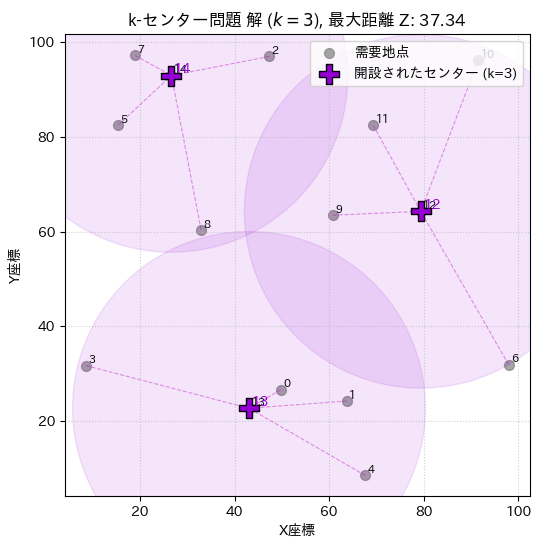

In [ ]:
#@title 結果の可視化
if status_kcenter == mip.OptimizationStatus.OPTIMAL or status_kcenter == mip.OptimizationStatus.FEASIBLE:
    minimized_max_dist = Z_kc.x # model_kcenter.objective_value と同じはず
    opened_centers = [j for j in J_nodes_kc if y_kc[j].x >= 0.99]
    assignments_kc = {}
    actual_distances = []
    for i in I_nodes_kc:
        for j in J_nodes_kc:
            if x_kc[(i,j)].x >= 0.99:
                assignments_kc[i] = j
                actual_distances.append(dist_matrix_kc[i,j])
                break

    # 結果の可視化
    plt.figure(figsize=(6,6))
    # 需要地点のプロット
    plt.scatter(locations_coords_kc[:,0], locations_coords_kc[:,1], c='gray', marker='o', label='需要地点', alpha=0.7, s=50)
    for i in I_nodes_kc:
        plt.text(locations_coords_kc[i,0]+0.5, locations_coords_kc[i,1]+0.5, str(i), fontsize=8)

    # 開設されたセンターのプロット
    center_plot_coords = locations_coords_kc[opened_centers,:]
    plt.scatter(center_plot_coords[:,0], center_plot_coords[:,1], c='darkviolet', marker='P', s=200, label=f'開設されたセンター (k={k_centers_to_locate})', edgecolors='black', zorder=3)
    for center_idx in opened_centers:
         plt.text(locations_coords_kc[center_idx,0]+0.5, locations_coords_kc[center_idx,1]+0.5, str(center_idx), fontsize=10, color='darkviolet', weight='bold', zorder=4)

    # 割り当て線のプロット
    for i in I_nodes_kc:
        assigned_j = assignments_kc.get(i)
        if assigned_j is not None:
            plt.plot([locations_coords_kc[i,0], locations_coords_kc[assigned_j,0]],
                     [locations_coords_kc[i,1], locations_coords_kc[assigned_j,1]],
                     'm--', alpha=0.4, linewidth=0.8, zorder=2)

    # 最大距離を示す円（カバレッジ円）を描画
    for center_idx in opened_centers:
        circle = plt.Circle((locations_coords_kc[center_idx,0], locations_coords_kc[center_idx,1]), minimized_max_dist,
                            color='darkviolet', alpha=0.1, zorder=1)
        plt.gca().add_artist(circle)

    plt.xlabel("X座標")
    plt.ylabel("Y座標")
    plt.title(f"k-センター問題 解 ($k={k_centers_to_locate}$), 最大距離 Z: {minimized_max_dist:.2f}")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')
    plt.show()

elif status_kcenter == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。制約条件（特にkの値）を見直してください。")
elif status_kcenter == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print(f"解が見つかりませんでした（時間制限: {time_limit_kcenter_sec}秒）。")
else:
    print(f"最適化ステータス: {status_kcenter}")

### モデルの拡張と関連問題

k-センター問題も、様々なバリエーションや関連問題が存在する。

  * **容量制約付きk-センター問題 (Capacitated k-Center Problem)**:
    各センターがサービスを提供できる需要地点の数や総需要量に上限（容量）がある場合。
  * **重み付きk-センター問題 (Weighted k-Center Problem)**:
    各需要地点に重要度や優先度（重み）が設定されており、距離にその重みを乗じたものの最大値を最小化するなど、重みを考慮した公平性を目指す場合。
  * **絶対k-センター問題 (Absolute k-Center / Euclidean k-Center Problem)**:
    施設（センター）を離散的な候補地点だけでなく、連続空間（例：ユークリッド平面）上の任意の点に配置できる問題。この場合、解法や問題の特性が異なる。
  * **離散k-センター問題 (Discrete k-Center Problem)**:
    本講義で扱ったように、施設を事前に定められた候補地点の集合から選ぶ問題。
  * **近似アルゴリズム**:
    k-センター問題もNP困難であるため、大規模なインスタンスに対しては近似アルゴリズムが重要となる。

k-メディアン問題とk-センター問題は、施設配置問題における基本的な二大柱であり、それぞれの目的関数の違いを理解することが、適切なモデル選択に繋がる。

---
#演習問題

##演習問題 1:

上記「問題データの設定」セクションで生成された15地点のデータと
$k=5$ を用いてk-センター問題を解き、
最適値（最小化された最大距離）を求めよ。

##演習問題 2:

演習問題1と同じ15地点のデータを用い開設するセンター数 $k$ を $2$ に変更し
k-センター問題を解き、
最適値（最小化された最大距離）を求めよ。


##演習問題 3

距離行列 $d_{ij}$ をユークリッド距離ではなく、
マンハッタン距離に変更して演習問題1のデータ ($k=3$) でk-センター問題を解き、
最適値（最小化された最大距離）を求めよ。

##演習問題 4
上記「問題データの設定」セクションで生成された15地点のデータ($k=3$)において、
地点インデックス 0 に必ずセンターを設置するという制約を加えk-センター問題を解き、
最適値（最小化された最大距離）を求めよ。

